## parameter estimation for I_HMM

In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import pygwalker as pyg
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.I_HMM import I_HMM
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.fixations.FixAlgos import *

In [2]:
# get viewings
n = 200
all_trials = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_real_trials.csv")
n_trials = len(all_trials)
print(n_trials)
r_inds = np.random.randint(0, n_trials, n)
rand_trials = list(all_trials.trial_id.to_numpy()[r_inds])
        
viewings = []
for t in rand_trials:
    viewings.append(f"{t}_enc")
    viewings.append(f"{t}_ret")

# viewings = ['alloeye_3r2_13_ret']
timepoints = fetch_timepoints("all", viewing_id=viewings)
print(timepoints.shape)

p_tps = []
n_viewings = len(viewings)
# preprocess
for i in range(n_viewings):
    # ind = random.randint(0, len(viewings)-1)
    viewing = viewings[i]
    # viewing = "alloeye_52r2_17_ret"

    # print(viewing)
    tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
    if tps is None or len(tps) < 2:
        p_tps.append(None)
        continue
    # print(viewings[i])
    # print(tps.shape)
    s_tps = SignalProcessor.sandwiched_gp_filter(tps.copy(deep=True))
    b_tps = BlinkProcessor(s_tps.copy(deep=True), max_blink_duration=1000, d_impute_threshold=0.16, impute_buffer_duration=8).timepoints
    if b_tps is None:
        print(f"{viewing} all blinks?")
        p_tps.append(None)
        continue
    f_tps = SignalProcessor.filter_timepoints(b_tps.copy(deep=True))
    p_tps.append(f_tps)

2915
executing query
SELECT * FROM "alloeye_timepoint_viewing" WHERE retrieval_epoch in ('na', 'view') and viewing_id in ('alloeye_10r1_3_enc', 'alloeye_10r1_3_ret', 'alloeye_14r2_2_enc', 'alloeye_14r2_2_ret', 'alloeye_29r1_1_enc', 'alloeye_29r1_1_ret', 'alloeye_12r1_17_enc', 'alloeye_12r1_17_ret', 'alloeye_20r2_3_enc', 'alloeye_20r2_3_ret', 'alloeye_42r3_8_enc', 'alloeye_42r3_8_ret', 'alloeye_58r2_16_enc', 'alloeye_58r2_16_ret', 'alloeye_8r2_13_enc', 'alloeye_8r2_13_ret', 'alloeye_29r1_2_enc', 'alloeye_29r1_2_ret', 'alloeye_56r1_4_enc', 'alloeye_56r1_4_ret', 'alloeye_45r1_3_enc', 'alloeye_45r1_3_ret', 'alloeye_6r3_15_enc', 'alloeye_6r3_15_ret', 'alloeye_31r3_4_enc', 'alloeye_31r3_4_ret', 'alloeye_44r3_17_enc', 'alloeye_44r3_17_ret', 'alloeye_44r1_6_enc', 'alloeye_44r1_6_ret', 'alloeye_57r2_17_enc', 'alloeye_57r2_17_ret', 'alloeye_4r3_17_enc', 'alloeye_4r3_17_ret', 'alloeye_15r3_5_enc', 'alloeye_15r3_5_ret', 'alloeye_45r2_16_enc', 'alloeye_45r2_16_ret', 'alloeye_54r1_8_enc', 'alloeye_5

,timepoint_id,trial_or_all,ppt_id,study_id,block_id,trial_id,viewing_id,retrieval_epoch,eye_timestamp_ms,unity_timestamp,...,gaze_collision_no_table_z,trackloss,tech_trackloss,blink,blink_imputed,start_blink,end_blink,missing,aoi_hit,new_misses


In [5]:
startprobs, transmats, meanss, covarss = [], [], [], []

def order_params(model):
    fix_idx = np.argmin(model.means_)
    sacc_idx = np.argmax(model.means_)
    means = np.array([model.means_[fix_idx], model.means_[sacc_idx]])
    transmat = np.array([[model.transmat_[fix_idx, fix_idx], model.transmat_[fix_idx, sacc_idx]],
                         [model.transmat_[sacc_idx, fix_idx], model.transmat_[sacc_idx, sacc_idx]]]).reshape(1, 2, 2)
    covars = np.array([model.covars_[fix_idx], model.covars_[sacc_idx]])
    startprob = np.array([model.startprob_[fix_idx], model.startprob_[sacc_idx]])
    return startprob, transmat, means, covars
    
for i in range(5):
    if p_tps[i] is None:
        continue
    model = I_HMM(p_tps[i]).train_model()
    if i == 0:
        startprobs, transmats, meanss, covarss = order_params(model)
    else:
        s, t, m, c = order_params(model)
        startprobs = np.vstack((startprobs, s))
        transmats = np.vstack((transmats, t))
        meanss = np.dstack((meanss, m))
        covarss = np.dstack((covarss, c))



In [6]:
startprobs_m = np.mean(startprobs, axis=0)
transmat_m = np.mean(transmats, axis=0)
means_m = np.mean(meanss, axis=2)
covars_m = np.mean(covarss, axis=2)

In [7]:
print(f"startprob_: np.array([{startprobs_m[0]}, {startprobs_m[1]}])")
print(f"transmat: np.array([[{transmat_m[0, 0]}, {transmat_m[0, 1]}], [{transmat_m[1, 0]}, {transmat_m[1, 1]}]])" )
print(f"means:  np.array([{means_m[0]}, {means_m[1]}])")
print(f"covars:  np.array([{covars_m[0]}, {covars_m[1]}])" )

startprob_: np.array([0.9999999271603389, 7.283966106505518e-08])
transmat: np.array([[0.9499550174395448, 0.05004498256045514], [0.1894995436920064, 0.8105004563079936]])
means:  np.array([[0.00866825], [0.12547113]])
covars:  np.array([[8.23893934e-05], [0.00949561]])


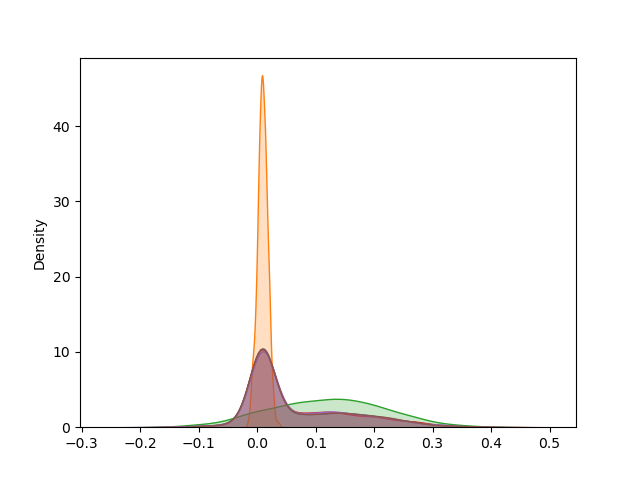

In [11]:
from scipy.stats import norm

# Create the two Gaussian distributions
dist1 = norm(means_m[0], np.sqrt(covars_m[0]))
dist2 = norm(means_m[1], np.sqrt(covars_m[1]))

# Generate data from the two distributions
data1 = dist1.rvs(1000)
data2 = dist2.rvs(1000)

# Combine the data into a single array
data = np.concatenate((data1, data2))

# Plot the density plot using seaborn
sns.kdeplot(data, shade=True, label='Combined Distribution')
sns.kdeplot(data1, shade=True, label='Distribution 1')
sns.kdeplot(data2, shade=True, label='Distribution 2')
plt.show()